In [ ]:
import pandas as pd

weather = pd.read_csv('WeatherData/weather_jfk.csv', index_col="DATE")

In [ ]:
weather

In [ ]:
# weather = weather.loc['1985':]
weather


filtered for newer data than 1985, so that i get more non null columns

In [ ]:
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]

In [ ]:
null_pct

removing the data where the null percentage is more than 5% in order to clean the data

In [ ]:
valid_columns = weather.columns[null_pct < 0.05]

In [ ]:
valid_columns

In [ ]:
weather = weather[valid_columns].copy()

In [ ]:
weather.columns = weather.columns.str.lower()

In [ ]:
weather

In [ ]:
weather.apply(pd.isnull).sum()

In [ ]:
weather.ffill(inplace=True)

replacing all missing values with a value from the previous row, so that the data is continuous

In [ ]:
weather.apply(pd.isnull).sum()

In [ ]:
weather.dtypes

In [ ]:
weather.index

In [ ]:
weather.index = pd.to_datetime(weather.index)

changing the index data type to data 

In [ ]:
weather.index.year.value_counts().sort_index()

In [ ]:
weather['tmax'].plot()

In [ ]:
weather["target"] = weather.shift(-1)["tmax"]
weather

In [ ]:
weather = weather.ffill()
weather

In [ ]:
numeric_columns = weather.select_dtypes(include=["float", "int"]).columns
weather[numeric_columns].corr()


In [ ]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [ ]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]
predictors

In [ ]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i:(i+step), :]

        model.fit(train[predictors], train["target"])

        predictions = model.predict(test[predictors])

        predictions = pd.Series(predictions, index=test.index)
        combined = pd.concat([test["target"], predictions], axis=1)

        combined.columns = ["actual", "predicted"]

        combined["diff"] = (combined["actual"] - combined["predicted"]).abs()

        all_predictions.append(combined)

    return pd.concat(all_predictions)


In [ ]:
predictions = backtest(weather, rr, predictors)
predictions

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(predictions["actual"], predictions["predicted"])

In [ ]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"

    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])

    return weather

rolling_horizons = [3, 14]

for horizon in rolling_horizons:
    for col in ["tmax", "tmin", "prcp"]:
        weather = compute_rolling(weather, horizon, col)

weather

In [ ]:
weather = weather.iloc[14:, :]
weather

In [ ]:
weather = weather.fillna(0)

In [214]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["tmax", "tmin", "prcp"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day, group_keys=False).apply(expand_mean)
    

weather

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,...,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-15,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,29,13,36.0,29.666667,-0.022472,...,18.857143,-0.310606,0.022857,-1.000000,29.000000,29.000000,13.000000,13.000000,0.000000,0.000000
1970-01-16,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,36,21,43.0,30.333333,0.186813,...,18.785714,0.117871,0.022857,-1.000000,32.500000,36.000000,17.000000,21.000000,0.000000,0.000000
1970-01-17,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.02,0.0,0.0,43,30,42.0,36.000000,0.194444,...,19.142857,0.567164,0.022857,-0.125000,36.000000,43.000000,21.333333,30.000000,0.006667,0.020000
1970-01-18,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.10,0.0,0.0,42,25,25.0,40.333333,0.041322,...,19.285714,0.296296,0.030000,2.333333,37.500000,42.000000,22.250000,25.000000,0.030000,0.100000
1970-01-19,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,25,16,24.0,36.666667,-0.318182,...,18.928571,-0.154717,0.030000,-1.000000,35.000000,25.000000,21.000000,16.000000,0.024000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.08,0.0,0.0,67,54,58.0,67.000000,0.000000,...,50.785714,0.063291,0.233571,-0.657492,64.843462,61.523659,50.225905,47.216088,0.115316,0.110300
2022-10-18,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,58,48,56.0,63.666667,-0.089005,...,50.857143,-0.056180,0.135000,-1.000000,64.839264,61.458991,50.224540,47.091483,0.115245,0.110962
2022-10-19,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,56,43,61.0,60.333333,-0.071823,...,50.000000,-0.140000,0.095714,-1.000000,64.833844,61.422713,50.220110,46.992114,0.115175,0.110647


In [ ]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]
predictors

In [ ]:
predictions = backtest(weather, rr, predictors)
predictions

mean_absolute_error(predictions["actual"], predictions["predicted"])



In [ ]:
predictions.sort_values("diff", ascending=False)

In [ ]:
weather.loc["1990-03-07":"1990-03-17"]

In [ ]:
predictions["diff"].round().value_counts().sort_index().plot()

try xgboost, lightgbm, catboost, and random forest to see which one is the best

-- XGBOOST SECTION --

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(weather[predictors], weather["target"], test_size=0.2, random_state=42)

In [166]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor

pipe = Pipeline([
    ("target_encoder", TargetEncoder()),
    ("xgb", XGBRegressor())
])
pipe.fit(X_train, y_train)



Pipeline(steps=[('target_encoder', TargetEncoder(cols=[])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [167]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, pipe.predict(X_test))



4.974245447933133

In [168]:
from sklearn.model_selection import GridSearchCV

param_grid = {"xgb__n_estimators": [100, 200, 300], "xgb__max_depth": [3, 5, 7], "xgb__learning_rate": [0.01, 0.1, 0.3]}

grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

params = grid.best_params_

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}


In [171]:
def backtest_xgboost(weather, model, predictors, model_params, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i : (i + step), :]

        model.set_params(**model_params)
        model.fit(train[predictors], train["target"])

        predictions = model.predict(test[predictors])

        predictions = pd.Series(predictions, index=test.index)
        combined = pd.concat([test["target"], predictions], axis=1)
        combined.columns = ["actual", "predicted"]
        combined["diff"] = (combined["actual"] - combined["predicted"]).abs()

        all_predictions.append(combined)

    return pd.concat(all_predictions)

In [218]:
predictions_xgboost = backtest_xgboost(weather, pipe, predictors, params)
mean_absolute_error(predictions_xgboost["actual"], predictions_xgboost["predicted"])

KeyboardInterrupt: 

In [176]:
predictions_xgboost

,actual,predicted,diff
DATE,,,
1980-01-13,54.0,35.269497,18.730503
1980-01-14,51.0,45.255039,5.744961
1980-01-15,45.0,46.239704,1.239704
1980-01-16,40.0,46.611671,6.611671
1980-01-17,41.0,43.140797,2.140797
...,...,...,...
2022-10-17,58.0,65.856873,7.856873
2022-10-18,56.0,61.493690,5.493690
2022-10-19,61.0,59.270218,1.729782


In [219]:
import joblib

joblib.dump(grid, "weather_model.pkl")

model = joblib.load("weather_model.pkl")

model.predict(X_test)

model.best_params_

model.best_score_

model.best_estimator_

model.best_estimator_.named_steps["xgb"].feature_importances_

mean_absolute_error(y_test, model.predict(X_test))

4.767299933130484

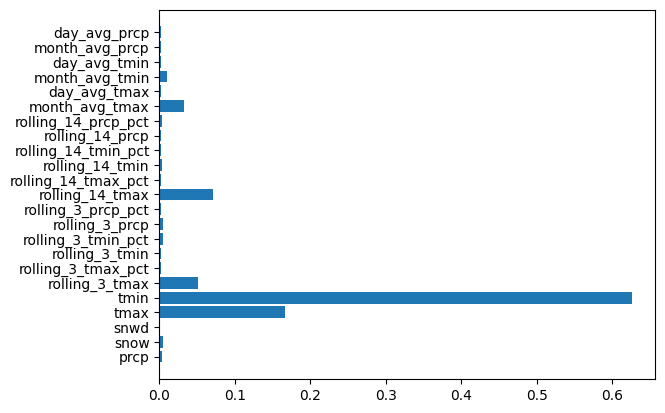

In [220]:
import matplotlib.pyplot as plt

plt.barh(X_train.columns, model.best_estimator_.named_steps["xgb"].feature_importances_)
plt.show()

<Axes: xlabel='diff'>

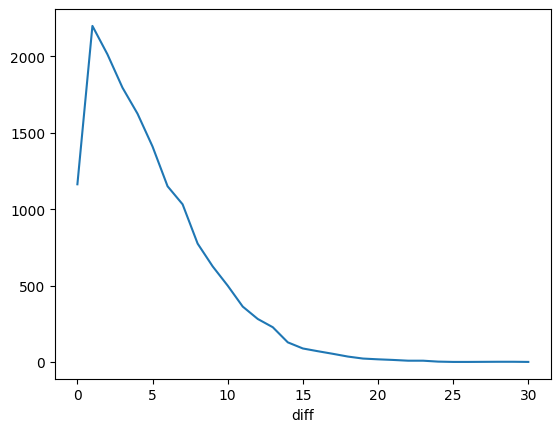

In [221]:
predictions_xgboost["diff"].round().value_counts().sort_index().plot()

-- NEURAL NETWORKS -- 

In [222]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model(input_shape):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_shape,)),
        Dense(64, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mae")

    return model

model = build_model(X_train.shape[1])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [223]:
def backtest_neural_network(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i : (i + step), :]

        X_train, y_train = train[predictors], train["target"]
        X_test, y_test = test[predictors], test["target"]

        model.fit(
            X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0
        )

        predictions = model.predict(
            X_test
        ).flatten()  # Otrzymujemy przewidywane wartości

        predictions_df = pd.DataFrame(
            {
                "actual": y_test.values,
                "predicted": predictions,
                "diff": (y_test.values - predictions),
            },
            index=y_test.index,
        )

        all_predictions.append(predictions_df)

    return pd.concat(all_predictions)

In [224]:
predictions_neural_network = backtest_neural_network(weather, model, predictors)
joblib.dump(predictions_neural_network, "predictions_neural_network.pkl")
mean_absolute_error(
    predictions_neural_network["actual"], predictions_neural_network["predicted"]
)

KeyboardInterrupt: 

In [ ]:
predictions_neural_network.sort_index()

,actual,predicted,diff
DATE,,,
1980-01-13,54.0,39.183907,14.816093
1980-01-14,51.0,51.511761,-0.511761
1980-01-15,45.0,46.693680,-1.693680
1980-01-16,40.0,42.294350,-2.294350
1980-01-17,41.0,41.402802,-0.402802
...,...,...,...
2022-10-17,58.0,66.884918,-8.884918
2022-10-18,56.0,61.212044,-5.212044
2022-10-19,61.0,60.148148,0.851852


In [ ]:
from tensorflow.keras import regularizers

# dodanie regularyzacji L1 do warstwy Dense
model.add(Dense(64, activation="relu", input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.01)))

predictions_neural_network = backtest_neural_network(weather, model, predictors)
joblib.dump(predictions_neural_network, "predictions_neural_network_l1.pkl")
mean_absolute_error(
    predictions_neural_network["actual"], predictions_neural_network["predicted"]
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━

5.0324779915335025

In [ ]:
model.add(Dense(64, activation="relu", input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)))

predictions_neural_network = backtest_neural_network(weather, model, predictors)
joblib.dump(predictions_neural_network, "predictions_neural_network_l2.pkl")
mean_absolute_error(
    predictions_neural_network["actual"], predictions_neural_network["predicted"]
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━

4.988881605226816

In [ ]:
mlp_l2 = joblib.load("predictions_neural_network_l2.pkl")
mlp_l2

,actual,predicted,diff
DATE,,,
1980-01-13,54.0,33.766613,20.233387
1980-01-14,51.0,51.532780,-0.532780
1980-01-15,45.0,44.200668,0.799332
1980-01-16,40.0,44.539459,-4.539459
1980-01-17,41.0,38.502106,2.497894
...,...,...,...
2022-10-17,58.0,67.018341,-9.018341
2022-10-18,56.0,60.224239,-4.224239
2022-10-19,61.0,59.402153,1.597847


In [ ]:
mlp_l1 = joblib.load("predictions_neural_network_l1.pkl")
mlp_l1

,actual,predicted,diff
DATE,,,
1980-01-13,54.0,34.348106,19.651894
1980-01-14,51.0,49.070404,1.929596
1980-01-15,45.0,43.405708,1.594292
1980-01-16,40.0,44.487289,-4.487289
1980-01-17,41.0,40.832237,0.167763
...,...,...,...
2022-10-17,58.0,66.165550,-8.165550
2022-10-18,56.0,59.724754,-3.724754
2022-10-19,61.0,59.385399,1.614601


-- random forest --

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=5)

In [ ]:
def backtest_random_forest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i : (i + step), :]

        model.fit(train[predictors], train["target"])

        predictions = model.predict(test[predictors])

        predictions = pd.Series(predictions, index=test.index)
        combined = pd.concat([test["target"], predictions], axis=1)
        combined.columns = ["actual", "predicted"]
        combined["diff"] = (combined["actual"] - combined["predicted"]).abs()

        all_predictions.append(combined)

    return pd.concat(all_predictions)

In [ ]:
predictions_rf = backtest_random_forest(weather, rf_model, predictors)
joblib.dump(predictions_rf, "predictions_rf.pkl")
mean_absolute_error(predictions_rf["actual"], predictions_rf["predicted"])

4.8779432797332225